In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
batch_size = 128
epochs = 100
latent_dim = 64
diffusion_steps = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [3]:
class VAEEncoder(nn.Module):
    def __init__(self, latent_dim, num_classes=10):
        super(VAEEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc_mu = nn.Linear(128 * 5 * 5 + num_classes, latent_dim)
        self.fc_var = nn.Linear(128 * 5 * 5 + num_classes, latent_dim)
        self.label_embedding = nn.Embedding(num_classes, num_classes)

    def forward(self, x, labels):
        x = F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = x.view(x.size(0), -1)
        label_emb = self.label_embedding(labels)
        x = torch.cat([x, label_emb], dim=1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var


class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, num_classes=10):
        super(VAEDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim + num_classes, 128 * 5 * 5)
        self.deconv1 = nn.ConvTranspose2d(128, 64, 3, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(64)
        self.deconv2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.deconv3 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)
        self.label_embedding = nn.Embedding(num_classes, num_classes)

    def forward(self, z, labels):
        label_emb = self.label_embedding(labels)
        x = torch.cat([z, label_emb], dim=1)
        x = self.fc(x)
        x = x.view(x.size(0), 128, 5, 5)
        x = F.leaky_relu(self.bn1(self.deconv1(x)), negative_slope=0.2)
        x = F.leaky_relu(self.bn2(self.deconv2(x)), negative_slope=0.2)
        x = torch.tanh(self.deconv3(x))
        return x

In [4]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = torch.exp(torch.arange(half_dim, device=device) * -np.log(10000) / (half_dim - 1))
        emb = t.unsqueeze(1) * emb.unsqueeze(0)
        return torch.cat([emb.sin(), emb.cos()], dim=1)

In [5]:
class LatentDiffusion(nn.Module):
    def __init__(self, latent_dim, num_classes=10):
        super().__init__()
        self.latent_dim = latent_dim
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        
        self.time_embed = nn.Sequential(
            TimeEmbedding(128),
            nn.Linear(128, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, 256),
        )

        self.net = nn.Sequential(
            nn.Linear(latent_dim + num_classes + 256, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, latent_dim),
        )

    def forward(self, z, labels, t):
        t_emb = self.time_embed(t)
        label_emb = self.label_embedding(labels)
        x = torch.cat([z, label_emb, t_emb], dim=1)
        return self.net(x)

In [6]:
class VAEDiffusionModel(nn.Module):
    def __init__(self, latent_dim, num_classes=10, diffusion_steps=1000):
        super(VAEDiffusionModel, self).__init__()
        self.latent_dim = latent_dim
        self.diffusion_steps = diffusion_steps
        self.encoder = VAEEncoder(latent_dim, num_classes)
        self.decoder = VAEDecoder(latent_dim, num_classes)
        self.diffusion = LatentDiffusion(latent_dim, num_classes)
        self.register_buffer('beta', torch.linspace(0.0001, 0.02, diffusion_steps))
        self.register_buffer('alpha', 1.0 - self.beta)
        self.register_buffer('alpha_bar', torch.cumprod(self.alpha, dim=0))

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def vae_loss(self, x, labels):
        mu, log_var = self.encoder(x, labels)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(z, labels)
        recon_loss = F.mse_loss(x_recon, x)
        kl_loss = -0.5 * torch.mean(1 + log_var - mu**2 - log_var.exp())
        return recon_loss, kl_loss, z

    def diffusion_loss(self, z0, labels):
        batch_size = z0.size(0)
        t = torch.randint(0, self.diffusion_steps, (batch_size,), device=z0.device)
        alpha_bar_t = self.alpha_bar[t].view(-1, 1)
        noise = torch.randn_like(z0)
        z_t = torch.sqrt(alpha_bar_t) * z0 + torch.sqrt(1 - alpha_bar_t) * noise
        predicted_noise = self.diffusion(z_t, labels, t)
        return F.mse_loss(predicted_noise, noise)

    def forward(self, x, labels):
        recon_loss, kl_loss, z0 = self.vae_loss(x, labels)
        diffusion_loss = self.diffusion_loss(z0, labels)
        total_loss = 1.0 * recon_loss + 0.1 * kl_loss + 0.5 * diffusion_loss
        return total_loss, recon_loss, kl_loss, diffusion_loss

    def sample(self, num_samples, labels, device):
        with torch.no_grad():
            z = torch.randn(num_samples, self.latent_dim).to(device)
            
            for t in reversed(range(self.diffusion_steps)):
                t_batch = torch.full((num_samples,), t, device=device, dtype=torch.float32)
                alpha_t = self.alpha[t]
                alpha_bar_t = self.alpha_bar[t]
                beta_t = self.beta[t]
                predicted_noise = self.diffusion(z, labels, t_batch)
                if alpha_bar_t > 0:
                    mean = (1 / torch.sqrt(alpha_t)) * (
                        z - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * predicted_noise
                    )
                else:
                    mean = torch.zeros_like(z)
                
                if t > 0:
                    z = mean + torch.sqrt(beta_t) * torch.randn_like(z)
                else:
                    z = mean
            samples = self.decoder(z, labels)
            return samples

Epoch 1/100, Total: 0.3626, Recon: 0.1366, KL: 0.6329, Diff: 0.3255
Epoch 2/100, Total: 0.2438, Recon: 0.0654, KL: 0.6725, Diff: 0.2223
Epoch 3/100, Total: 0.2298, Recon: 0.0581, KL: 0.6517, Diff: 0.2131
Epoch 4/100, Total: 0.2250, Recon: 0.0544, KL: 0.6425, Diff: 0.2128
Epoch 5/100, Total: 0.2207, Recon: 0.0521, KL: 0.6327, Diff: 0.2105
Epoch 6/100, Total: 0.2167, Recon: 0.0506, KL: 0.6234, Diff: 0.2076
Epoch 7/100, Total: 0.2149, Recon: 0.0494, KL: 0.6230, Diff: 0.2063
Epoch 8/100, Total: 0.2125, Recon: 0.0485, KL: 0.6180, Diff: 0.2044
Epoch 9/100, Total: 0.2111, Recon: 0.0476, KL: 0.6175, Diff: 0.2033
Epoch 10/100, Total: 0.2092, Recon: 0.0469, KL: 0.6107, Diff: 0.2025


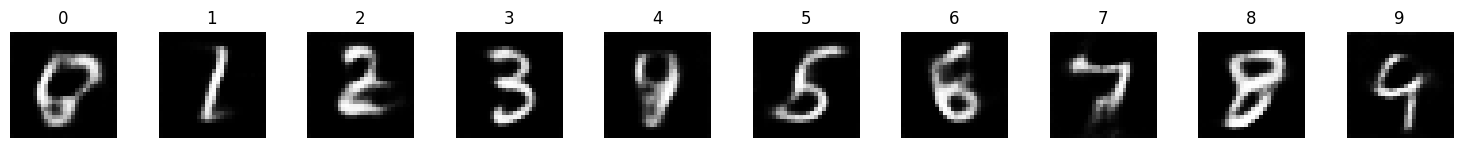

Epoch 11/100, Total: 0.2084, Recon: 0.0463, KL: 0.6151, Diff: 0.2013
Epoch 12/100, Total: 0.2065, Recon: 0.0457, KL: 0.6113, Diff: 0.1992
Epoch 13/100, Total: 0.2060, Recon: 0.0453, KL: 0.6088, Diff: 0.1997
Epoch 14/100, Total: 0.2059, Recon: 0.0448, KL: 0.6092, Diff: 0.2003
Epoch 15/100, Total: 0.2054, Recon: 0.0445, KL: 0.6087, Diff: 0.2001
Epoch 16/100, Total: 0.2059, Recon: 0.0442, KL: 0.6095, Diff: 0.2017
Epoch 17/100, Total: 0.2052, Recon: 0.0437, KL: 0.6046, Diff: 0.2019
Epoch 18/100, Total: 0.2027, Recon: 0.0435, KL: 0.6025, Diff: 0.1980
Epoch 19/100, Total: 0.2035, Recon: 0.0432, KL: 0.6001, Diff: 0.2005
Epoch 20/100, Total: 0.2017, Recon: 0.0429, KL: 0.5988, Diff: 0.1979


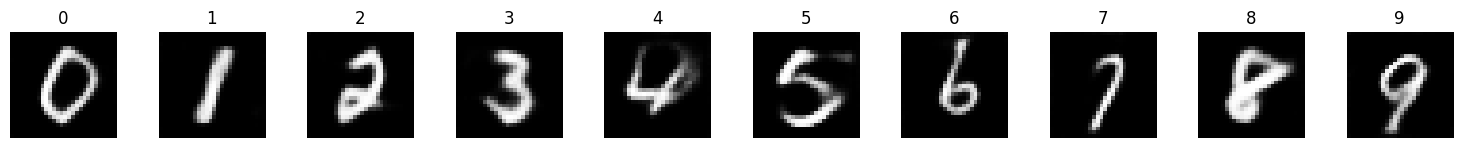

Epoch 21/100, Total: 0.2008, Recon: 0.0427, KL: 0.5976, Diff: 0.1967
Epoch 22/100, Total: 0.2007, Recon: 0.0425, KL: 0.5975, Diff: 0.1970
Epoch 23/100, Total: 0.2005, Recon: 0.0422, KL: 0.5986, Diff: 0.1969
Epoch 24/100, Total: 0.1995, Recon: 0.0420, KL: 0.5922, Diff: 0.1966
Epoch 25/100, Total: 0.2012, Recon: 0.0419, KL: 0.5997, Diff: 0.1987
Epoch 26/100, Total: 0.1995, Recon: 0.0417, KL: 0.5942, Diff: 0.1968
Epoch 27/100, Total: 0.1994, Recon: 0.0415, KL: 0.5945, Diff: 0.1969
Epoch 28/100, Total: 0.1989, Recon: 0.0413, KL: 0.5944, Diff: 0.1964
Epoch 29/100, Total: 0.1998, Recon: 0.0411, KL: 0.5959, Diff: 0.1983
Epoch 30/100, Total: 0.1982, Recon: 0.0410, KL: 0.5895, Diff: 0.1964


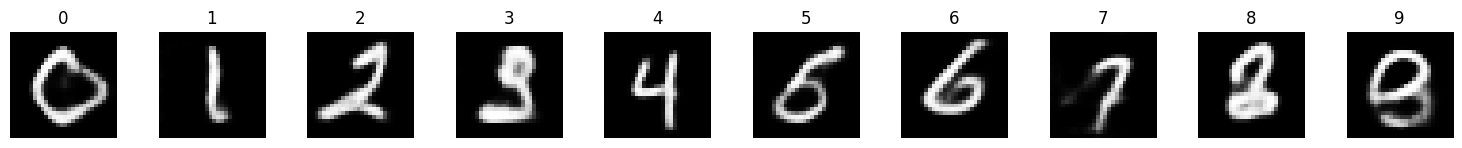

Epoch 31/100, Total: 0.1992, Recon: 0.0409, KL: 0.5894, Diff: 0.1987
Epoch 32/100, Total: 0.1936, Recon: 0.0395, KL: 0.5898, Diff: 0.1902
Epoch 33/100, Total: 0.1937, Recon: 0.0392, KL: 0.5920, Diff: 0.1905
Epoch 34/100, Total: 0.1945, Recon: 0.0391, KL: 0.5952, Diff: 0.1917
Epoch 35/100, Total: 0.1949, Recon: 0.0391, KL: 0.5943, Diff: 0.1927
Epoch 36/100, Total: 0.1945, Recon: 0.0390, KL: 0.5956, Diff: 0.1918
Epoch 37/100, Total: 0.1936, Recon: 0.0389, KL: 0.5898, Diff: 0.1915
Epoch 38/100, Total: 0.1938, Recon: 0.0389, KL: 0.5925, Diff: 0.1913
Epoch 39/100, Total: 0.1931, Recon: 0.0388, KL: 0.5902, Diff: 0.1905
Epoch 40/100, Total: 0.1930, Recon: 0.0387, KL: 0.5926, Diff: 0.1900


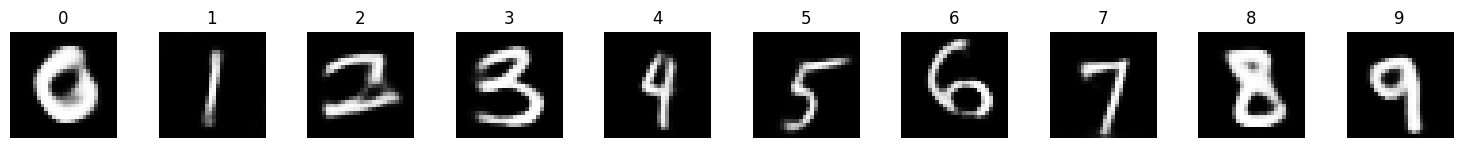

Epoch 41/100, Total: 0.1939, Recon: 0.0386, KL: 0.5931, Diff: 0.1919
Epoch 42/100, Total: 0.1938, Recon: 0.0386, KL: 0.5910, Diff: 0.1922
Epoch 43/100, Total: 0.1936, Recon: 0.0385, KL: 0.5927, Diff: 0.1917
Epoch 44/100, Total: 0.1932, Recon: 0.0385, KL: 0.5906, Diff: 0.1912
Epoch 45/100, Total: 0.1929, Recon: 0.0385, KL: 0.5896, Diff: 0.1909
Epoch 46/100, Total: 0.1930, Recon: 0.0384, KL: 0.5915, Diff: 0.1909
Epoch 47/100, Total: 0.1936, Recon: 0.0384, KL: 0.5938, Diff: 0.1916
Epoch 48/100, Total: 0.1931, Recon: 0.0383, KL: 0.5900, Diff: 0.1915
Epoch 49/100, Total: 0.1923, Recon: 0.0384, KL: 0.5880, Diff: 0.1903
Epoch 50/100, Total: 0.1939, Recon: 0.0383, KL: 0.5918, Diff: 0.1929


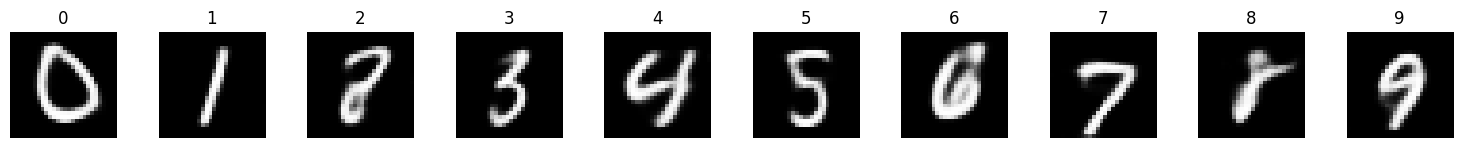

Epoch 51/100, Total: 0.1931, Recon: 0.0383, KL: 0.5923, Diff: 0.1912
Epoch 52/100, Total: 0.1924, Recon: 0.0382, KL: 0.5866, Diff: 0.1910
Epoch 53/100, Total: 0.1933, Recon: 0.0381, KL: 0.5898, Diff: 0.1924
Epoch 54/100, Total: 0.1916, Recon: 0.0381, KL: 0.5867, Diff: 0.1896
Epoch 55/100, Total: 0.1911, Recon: 0.0381, KL: 0.5864, Diff: 0.1887
Epoch 56/100, Total: 0.1910, Recon: 0.0380, KL: 0.5847, Diff: 0.1889
Epoch 57/100, Total: 0.1926, Recon: 0.0380, KL: 0.5868, Diff: 0.1917
Epoch 58/100, Total: 0.1923, Recon: 0.0379, KL: 0.5892, Diff: 0.1910
Epoch 59/100, Total: 0.1916, Recon: 0.0379, KL: 0.5862, Diff: 0.1902
Epoch 60/100, Total: 0.1907, Recon: 0.0378, KL: 0.5883, Diff: 0.1880


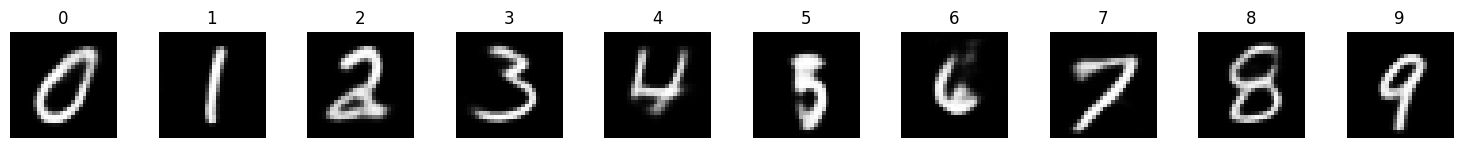

Epoch 61/100, Total: 0.1927, Recon: 0.0379, KL: 0.5878, Diff: 0.1920
Epoch 62/100, Total: 0.1916, Recon: 0.0378, KL: 0.5880, Diff: 0.1899
Epoch 63/100, Total: 0.1918, Recon: 0.0378, KL: 0.5864, Diff: 0.1907
Epoch 64/100, Total: 0.1913, Recon: 0.0378, KL: 0.5841, Diff: 0.1903
Epoch 65/100, Total: 0.1926, Recon: 0.0378, KL: 0.5833, Diff: 0.1930
Epoch 66/100, Total: 0.1914, Recon: 0.0378, KL: 0.5808, Diff: 0.1912
Epoch 67/100, Total: 0.1912, Recon: 0.0377, KL: 0.5829, Diff: 0.1905
Epoch 68/100, Total: 0.1916, Recon: 0.0377, KL: 0.5846, Diff: 0.1910
Epoch 69/100, Total: 0.1907, Recon: 0.0376, KL: 0.5814, Diff: 0.1900
Epoch 70/100, Total: 0.1906, Recon: 0.0376, KL: 0.5810, Diff: 0.1898


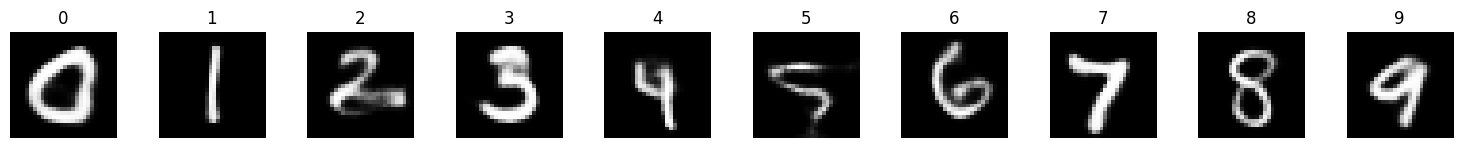

Epoch 71/100, Total: 0.1916, Recon: 0.0376, KL: 0.5823, Diff: 0.1917
Epoch 72/100, Total: 0.1917, Recon: 0.0375, KL: 0.5828, Diff: 0.1918
Epoch 73/100, Total: 0.1908, Recon: 0.0375, KL: 0.5810, Diff: 0.1905
Epoch 74/100, Total: 0.1904, Recon: 0.0375, KL: 0.5794, Diff: 0.1900
Epoch 75/100, Total: 0.1905, Recon: 0.0375, KL: 0.5825, Diff: 0.1897
Epoch 76/100, Total: 0.1921, Recon: 0.0374, KL: 0.5862, Diff: 0.1923
Epoch 77/100, Total: 0.1898, Recon: 0.0373, KL: 0.5796, Diff: 0.1890
Epoch 78/100, Total: 0.1920, Recon: 0.0373, KL: 0.5833, Diff: 0.1926
Epoch 79/100, Total: 0.1905, Recon: 0.0373, KL: 0.5797, Diff: 0.1905
Epoch 80/100, Total: 0.1915, Recon: 0.0373, KL: 0.5821, Diff: 0.1920


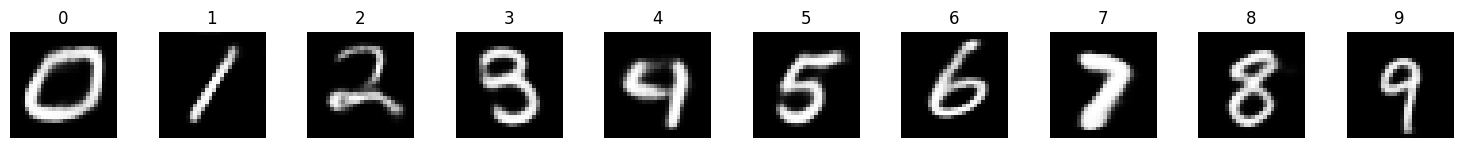

Epoch 81/100, Total: 0.1908, Recon: 0.0373, KL: 0.5812, Diff: 0.1908
Epoch 82/100, Total: 0.1902, Recon: 0.0372, KL: 0.5828, Diff: 0.1894
Epoch 83/100, Total: 0.1910, Recon: 0.0372, KL: 0.5829, Diff: 0.1912
Epoch 84/100, Total: 0.1903, Recon: 0.0372, KL: 0.5789, Diff: 0.1904
Epoch 85/100, Total: 0.1901, Recon: 0.0372, KL: 0.5779, Diff: 0.1902
Epoch 86/100, Total: 0.1898, Recon: 0.0371, KL: 0.5791, Diff: 0.1896
Epoch 87/100, Total: 0.1913, Recon: 0.0372, KL: 0.5800, Diff: 0.1922
Epoch 88/100, Total: 0.1898, Recon: 0.0371, KL: 0.5749, Diff: 0.1905
Epoch 89/100, Total: 0.1901, Recon: 0.0370, KL: 0.5775, Diff: 0.1907
Epoch 90/100, Total: 0.1907, Recon: 0.0370, KL: 0.5824, Diff: 0.1908


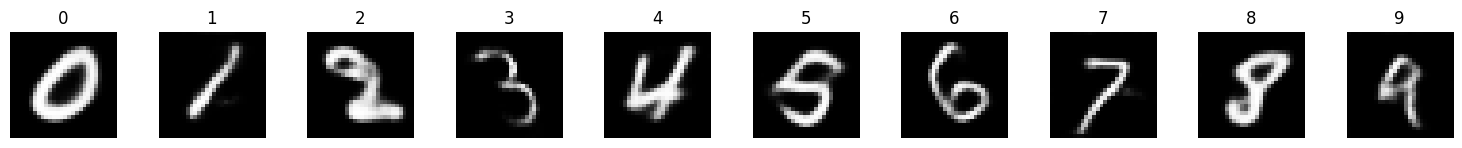

Epoch 91/100, Total: 0.1906, Recon: 0.0370, KL: 0.5801, Diff: 0.1912
Epoch 92/100, Total: 0.1897, Recon: 0.0370, KL: 0.5784, Diff: 0.1898
Epoch 93/100, Total: 0.1897, Recon: 0.0370, KL: 0.5792, Diff: 0.1896
Epoch 94/100, Total: 0.1907, Recon: 0.0369, KL: 0.5799, Diff: 0.1915
Epoch 95/100, Total: 0.1890, Recon: 0.0369, KL: 0.5746, Diff: 0.1892
Epoch 96/100, Total: 0.1899, Recon: 0.0368, KL: 0.5761, Diff: 0.1909
Epoch 97/100, Total: 0.1893, Recon: 0.0369, KL: 0.5779, Diff: 0.1894
Epoch 98/100, Total: 0.1904, Recon: 0.0368, KL: 0.5800, Diff: 0.1912
Epoch 99/100, Total: 0.1886, Recon: 0.0368, KL: 0.5738, Diff: 0.1889
Epoch 100/100, Total: 0.1898, Recon: 0.0368, KL: 0.5771, Diff: 0.1906


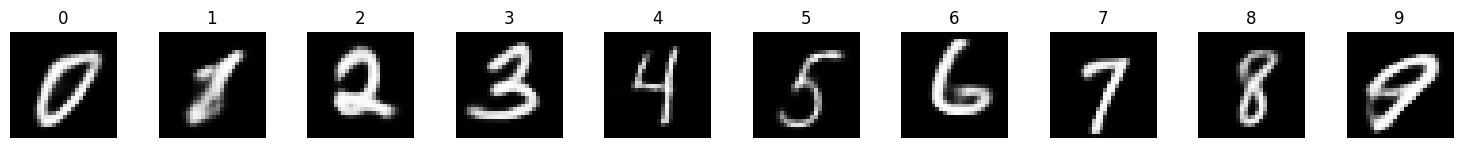

In [2]:
model = VAEDiffusionModel(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)


def train():
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total_recon_loss = 0.0
        total_kl_loss = 0.0
        total_diff_loss = 0.0
        
        for batch_idx, (data, labels) in enumerate(train_loader):
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            
            loss, recon_loss, kl_loss, diff_loss = model(data, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
            total_diff_loss += diff_loss.item()
        avg_loss = total_loss / len(train_loader)
        avg_recon = total_recon_loss / len(train_loader)
        avg_kl = total_kl_loss / len(train_loader)
        avg_diff = total_diff_loss / len(train_loader)
        
        print(
            f'Epoch {epoch+1}/{epochs}, '
            f'Total: {avg_loss:.4f}, '
            f'Recon: {avg_recon:.4f}, '
            f'KL: {avg_kl:.4f}, '
            f'Diff: {avg_diff:.4f}'
        )
        
        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                sample_labels = torch.arange(10).to(device)
                samples = model.sample(10, sample_labels, device)
                samples = (samples.cpu() + 1) / 2
                fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
                for i, ax in enumerate(axes):
                    ax.imshow(samples[i].squeeze(), cmap='gray')
                    ax.set_title(f'{i}')
                    ax.axis('off')
                plt.tight_layout()
                plt.show()
            model.train()


if __name__ == "__main__":
    train()
    